## Imports

In [20]:
"""Imports"""

import re
import json
from os import listdir
from os.path import isfile, join
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


## filter_res_by_cut_number

In [21]:
def filter_res_by_cut_number(cut_number, res_data):

    output = []
    for d in res_data:
        if d['number_of_cuts'] == cut_number:
            output.append(d)
    return output

## normalize_to_selected_frag_number

In [22]:
def normalize_to_selected_frag_number(res_data: list, properties_to_normalize: list[str], selected_frag_number: str, reciprocal: list[bool], keep_selected_frag_number: bool) -> list:

    # Initialize a dictionary to hold the sum of output values and count for each item
    item_outputs = {}

    # Loop through the dataset to group them based on sequence and cut number
    for d in res_data:
        key = (d["partition_search_method"], d["sequence"])
        if key not in set(item_outputs.keys()):
            item_outputs[key] = [d]
        if d not in item_outputs[key]:
            item_outputs[key].append(d)

    # Aggregate each group to one dict
    output = []
    for lst in item_outputs.values():
        for d in lst:
            out_d = d.copy()
            for property, reciprocal_ in zip(properties_to_normalize, reciprocal):
                property_of_each_frag_number = {d['number_of_fragments']: d[property] for d in lst}
                if property_of_each_frag_number[selected_frag_number] == 0:
                    normalized_value = float('nan')
                elif reciprocal_:
                    normalized_value = property_of_each_frag_number[selected_frag_number]/d[property]
                else:
                    normalized_value = d[property]/property_of_each_frag_number[selected_frag_number]
                out_d.update({f"{property}_normalized_to_{selected_frag_number}": normalized_value})
            output.append(out_d)

    if not keep_selected_frag_number:
        output = [d for d in output if d['number_of_fragments'] != selected_frag_number]

    return output


## normalize_to_selected_search_method

In [23]:
def normalize_to_selected_search_method(res_data: list, properties_to_normalize: list[str], selected_search_method: str, reciprocal: list[bool], keep_selected_search_method: bool) -> list:

    # Initialize a dictionary to hold the sum of output values and count for each item
    item_outputs = {}

    # Loop through the dataset to group them based on sequence and cut number
    for d in res_data:
        key = (d["number_of_cuts"], d["sequence"])
        if key not in set(item_outputs.keys()):
            item_outputs[key] = [d]
        if d not in item_outputs[key]:
            item_outputs[key].append(d)

    # Aggregate each group to one dict
    output = []
    for lst in item_outputs.values():
        for d in lst:
            out_d = d.copy()
            for property, reciprocal_ in zip(properties_to_normalize, reciprocal):
                property_of_each_method = {d['partition_search_method']: d[property] for d in lst}
                if property_of_each_method[selected_search_method] == 0:
                    normalized_value = float('nan')
                elif reciprocal_:
                    normalized_value = property_of_each_method[selected_search_method]/d[property]
                else:
                    normalized_value = d[property]/property_of_each_method[selected_search_method]
                out_d.update({f"{property}_normalized_to_{selected_search_method}": normalized_value})
            output.append(out_d)

    if not keep_selected_search_method:
        output = [d for d in output if d['partition_search_method'] != keep_selected_search_method]

    return output


In [30]:
s='GYMRFECQVIGDETFDKVEQMILGPCTQWPMHYDMQPNAYRACRDIEMSYMSFSYFDPAWKAWVIRTKNSISATLHEPSFPRFNRCLRCCKIDDRCCDWS'
len(s)

100

## jitter_box_plot

In [24]:
from matplotlib.ticker import FuncFormatter

def convert_plot_label_txt(txt):
    return re.sub("Of", "of", str.title(re.sub("_"," ",txt)))


# Custom formatter function for x-ticks
def format_ticks(x, pos):
    if x == 0:
        return r'10$^{4}$'
    elif x == 1:
        return r'10$^{6}$'
    elif x == 2:
        return r'10$^{8}$'
    elif x == 3:
        return r'10$^{10}$'
    else:
        return str(x)


def jitter_box_plot(x_axis, y_axis, df, my_palette, hue, logy=True):

    plt.figure(figsize=(8, 5))
    if logy:
        plt.yscale('symlog')
    else:
        plt.yscale('linear')

    label_loc = "upper left"
    # Using seaborn to plot with jitter and boxplot
    sns.boxplot(x=x_axis, y=y_axis, hue=hue, data=df, palette=my_palette, showfliers = False,
                boxprops=dict(facecolor='white', edgecolor="black", alpha=0.5),
                medianprops=dict(alpha=0.5),
                whiskerprops=dict(alpha=0.5),
                capprops=dict(alpha=0.5))
    sns.stripplot(x=x_axis, y=y_axis, hue=hue, data=df, palette=my_palette, dodge=True,
                  jitter=True, alpha=0.2, s=5, edgecolor='auto')
    plt.xlabel(str.title(re.sub('_',' ',x_axis)), fontsize=14)
    plt.title(f'{convert_plot_label_txt(y_axis)} vs {convert_plot_label_txt(x_axis)}; 300 AA',
              fontsize=16,
              pad=20)
    plt.tick_params(axis='both', labelsize=12)
    # Set the x-ticks and apply the formatter
    # plt.xticks([10000, 1000000, 100000000, 10000000000])
    plt.gca().xaxis.set_major_formatter(FuncFormatter(format_ticks))

    if y_axis == "ligation_fidelity":
        plt.ylim([0.95,1.05])
        plt.ylabel(f"{convert_plot_label_txt(y_axis)}", fontsize=14)

    if y_axis == "cost":
        plt.ylim([100,10000000000000])
        plt.ylabel(f"{convert_plot_label_txt(y_axis)} (\$, 0.1\$/bp, log scale)", fontsize=14)
        if x_axis != 'complexity':
            label_loc = "upper right"

    if y_axis == "elapsed_time":
        plt.ylim([0,10000000])
        plt.ylabel(f"{convert_plot_label_txt(y_axis)} (seconds, log scale)", fontsize=14)
        if x_axis == 'complexity':
            label_loc = "upper right"

    if y_axis == "number_of_partitions_checked":
        plt.ylim([0,1000000000])
        plt.ylabel(f"{convert_plot_label_txt(y_axis)} (log scale)", fontsize=14)
        if x_axis == 'complexity':
            label_loc = "upper right"

    # Adjust legend to avoid duplicate entries
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    legend = plt.legend(by_label.values(),
                        by_label.keys(),
                        title=convert_plot_label_txt(hue),
                        loc=label_loc,
                        ncols=2,
                        fontsize=12,
                        title_fontsize=12)
    for lh in legend.legend_handles:
        lh.set_alpha(1)
    # # legend.get_frame().set_alpha(None)
    # # legend.get_frame().set_facecolor((0, 0, 0, 0))

    return plt

## Import and prepare data

In [25]:
"""Import and prepare data"""
from proseqteleporter.utils.utils import compute_lib_complexity

parent_dirs = [
    r"C:\Users\GOFKV\PycharmProjects\proseqteleporter\experiments\same_complexity_diff_cost_10^7_max_cost300bp\fix_complexity_diff_muts_1M",
    r"C:\Users\GOFKV\PycharmProjects\proseqteleporter\experiments\same_complexity_diff_cost_10^7_max_cost300bp\fix_complexity_diff_muts_10k",
    r"C:\Users\GOFKV\PycharmProjects\proseqteleporter\experiments\same_complexity_diff_cost_10^7_max_cost300bp\fix_complexity_diff_muts_10B",
    r"C:\Users\GOFKV\PycharmProjects\proseqteleporter\experiments\same_complexity_diff_cost_10^7_max_cost300bp\fix_complexity_diff_muts_100M",
]

res_data = []
count = 0
for parent_dir in parent_dirs:
    result_dirs = [d for d in listdir(parent_dir) if not isfile(join(parent_dir, d))]
    print(result_dirs)

    for d in result_dirs:
        if re.search('checkpoint',d):
            continue
        param_file = join(parent_dir, d, "results", "params_dist_mut_1.json")
        with open(param_file, 'r') as fp:
            param = json.load(fp)
        mutations_0idx = param['mutations_0idx']
        linked_mutations_0idx = param['linked_mutations_0idx']
        assembly_cond = re.sub("^.*FileS[0-9][0-9]_|[.xlsx]","",param["fidelity_data_path"])
        # assembly_cond = param["fidelity_data_path"]
        diversity = compute_lib_complexity(mutations=mutations_0idx, linked_mutations=linked_mutations_0idx)

        result_files = [join(parent_dir, d, "results", f)
                        for f in listdir(join(parent_dir, d, "results")) if re.search('\dfrags',f)]
        # print(result_files)

        for file_path in result_files:
            count +=1
            with open(file_path, 'r') as fp:
                res_per_cut = json.load(fp)

                res_dict_ = {}
                number_checked = res_per_cut["number_of_partitions_checked"]
                uq_number_checked = res_per_cut["num_of_checked_unique_partitions"]
                hard_constraint_violations = sum([v for v in res_per_cut["hard_constraint_violations"].values()])
                if len(res_per_cut["sel_partitions"]) > 0:
                    ligation_fidelity = res_per_cut["sel_partitions"][0]["ligation_fidelity"]
                    fragment_length_unevenness = res_per_cut["sel_partitions"][0]["fragment_length_unevenness"]
                    cost = res_per_cut["sel_partitions"][0]["cost"]
                else:
                    print(file_path)
                    print(res_per_cut["hard_constraint_violations"])
                    continue
                    # ligation_fidelity = fragment_length_unevenness = cost = float("nan")
                res_dict_.update({
                    'f':file_path,
                    'partition_search_method':"distribute mut and only keep the best",
                    'assembly_condition': assembly_cond,
                    'sequence':param['s'],
                    'complexity': diversity,
                    'seq_length':len(param["s"]),
                    'mutation_positions':len(mutations_0idx),
                    'mutation_variations':sum([len(mut['aa']) for mut in mutations_0idx]),
                    'number_of_cuts':res_per_cut['number_of_cuts'],
                    'number_of_fragments':res_per_cut['number_of_cuts']+1,
                    'elapsed_time':res_per_cut['elapsed_time'],
                    "ligation_fidelity":ligation_fidelity,
                    "fragment_length_unevenness":fragment_length_unevenness,
                    "cost":cost/0.06*0.1,
                    "base_count":cost/0.06,
                    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5204324/
                    "number_of_partitions_checked":number_checked,
                    "num_of_checked_unique_partitions":uq_number_checked,
                    "pass_constraint_percentage": (number_checked-hard_constraint_violations)/number_checked * 100
                                 })
                res_data.append(res_dict_)
                res_dict_cp_ = res_dict_.copy()
                # res_dict_cp_.update({"cost":cost/0.06*0.18})
                # res_data.append(res_dict_cp_)
print(count)
df = pd.DataFrame([d for d in res_data if d['partition_search_method'] == "distribute mut and only keep the best"])
df

['input_rep0_2024-07-05output', 'input_rep10_2024-07-05output', 'input_rep11_2024-07-03output', 'input_rep12_2024-07-04output', 'input_rep13_2024-07-03output', 'input_rep14_2024-07-05output', 'input_rep15_2024-07-05output', 'input_rep16_2024-07-06output', 'input_rep17_2024-07-04output', 'input_rep18_2024-07-03output', 'input_rep19_2024-07-06output', 'input_rep1_2024-07-05output', 'input_rep20_2024-07-03output', 'input_rep21_2024-07-06output', 'input_rep22_2024-07-06output', 'input_rep23_2024-07-03output', 'input_rep24_2024-07-05output', 'input_rep25_2024-07-03output', 'input_rep26_2024-07-03output', 'input_rep27_2024-07-03output', 'input_rep28_2024-07-07output', 'input_rep29_2024-07-06output', 'input_rep2_2024-07-06output', 'input_rep30_2024-07-07output', 'input_rep31_2024-07-07output', 'input_rep32_2024-07-05output', 'input_rep33_2024-07-05output', 'input_rep34_2024-07-03output', 'input_rep35_2024-07-05output', 'input_rep36_2024-07-03output', 'input_rep37_2024-07-06output', 'input_rep

,f,partition_search_method,assembly_condition,sequence,complexity,seq_length,mutation_positions,mutation_variations,number_of_cuts,number_of_fragments,elapsed_time,ligation_fidelity,fragment_length_unevenness,cost,base_count,number_of_partitions_checked,num_of_checked_unique_partitions,pass_constraint_percentage
0,C:\Users\GOFKV\PycharmProjects\proseqteleporte...,distribute mut and only keep the best,T4_01h_25C,GYCYPHDGYGRHYVFMEGGRYVLISCWGGSIHADLLCNQYMRWLRF...,1000000,300,10,38,0,1,0.56,0.00,100.000,1.546667e+08,1.546667e+09,1,1,100.0
1,C:\Users\GOFKV\PycharmProjects\proseqteleporte...,distribute mut and only keep the best,T4_01h_25C,GYCYPHDGYGRHYVFMEGGRYVLISCWGGSIHADLLCNQYMRWLRF...,1000000,300,10,38,1,2,0.57,1.00,0.027,1.593333e+05,1.593333e+06,2,2,100.0
2,C:\Users\GOFKV\PycharmProjects\proseqteleporte...,distribute mut and only keep the best,T4_01h_25C,GYCYPHDGYGRHYVFMEGGRYVLISCWGGSIHADLLCNQYMRWLRF...,1000000,300,10,38,2,3,0.90,1.00,1.262,1.640000e+04,1.640000e+05,87,87,100.0
3,C:\Users\GOFKV\PycharmProjects\proseqteleporte...,distribute mut and only keep the best,T4_01h_25C,GYCYPHDGYGRHYVFMEGGRYVLISCWGGSIHADLLCNQYMRWLRF...,1000000,300,10,38,3,4,3.89,0.99,0.371,5.813333e+03,5.813333e+04,504,504,100.0
4,C:\Users\GOFKV\PycharmProjects\proseqteleporte...,distribute mut and only keep the best,T4_01h_25C,GYCYPHDGYGRHYVFMEGGRYVLISCWGGSIHADLLCNQYMRWLRF...,1000000,300,10,38,4,5,172.92,0.99,10.714,2.516667e+03,2.516667e+04,16536,16536,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,C:\Users\GOFKV\PycharmProjects\proseqteleporte...,distribute mut and only keep the best,T4_01h_25C,PNECMWQEGNAPKEKHLFCSQVMPESEGESLLFIFILSGVDCTQLP...,100000000,300,11,60,0,1,0.63,0.00,100.000,1.546667e+10,1.546667e+11,1,1,100.0
996,C:\Users\GOFKV\PycharmProjects\proseqteleporte...,distribute mut and only keep the best,T4_01h_25C,PNECMWQEGNAPKEKHLFCSQVMPESEGESLLFIFILSGVDCTQLP...,100000000,300,11,60,1,2,0.63,1.00,0.344,1.593333e+06,1.593333e+07,4,4,100.0
997,C:\Users\GOFKV\PycharmProjects\proseqteleporte...,distribute mut and only keep the best,T4_01h_25C,PNECMWQEGNAPKEKHLFCSQVMPESEGESLLFIFILSGVDCTQLP...,100000000,300,11,60,2,3,3.08,0.99,4.821,6.963333e+04,6.963333e+05,484,484,100.0
998,C:\Users\GOFKV\PycharmProjects\proseqteleporte...,distribute mut and only keep the best,T4_01h_25C,PNECMWQEGNAPKEKHLFCSQVMPESEGESLLFIFILSGVDCTQLP...,100000000,300,11,60,3,4,64.89,0.98,5.043,1.980000e+04,1.980000e+05,6336,6336,100.0


## Plotting - cost/complexity fitting

Number of Fragments = 1: log10(cost) = 1.0000 * log10(complexity) + 2.1894
Number of Fragments = 2: log10(cost) = 0.5068 * log10(complexity) + 2.2075
Number of Fragments = 3: log10(cost) = 0.3480 * log10(complexity) + 2.1579
Number of Fragments = 4: log10(cost) = 0.2620 * log10(complexity) + 2.1805
Number of Fragments = 5: log10(cost) = 0.2135 * log10(complexity) + 2.1801


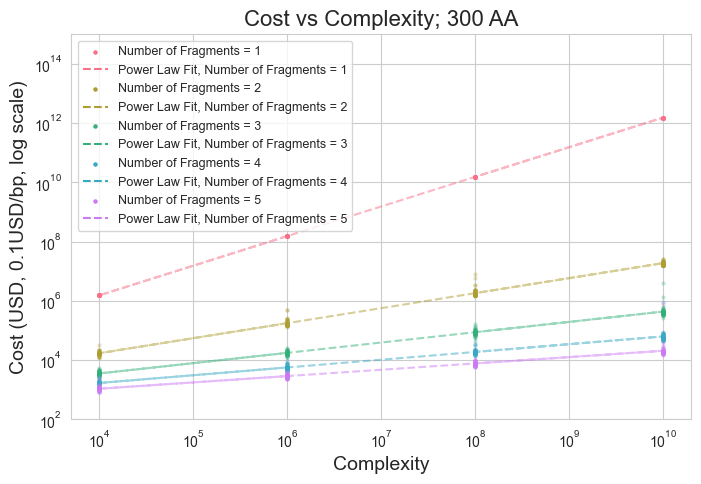

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

# Define the power-law function
def power_law(x, a, b):
    return np.power(10, (a * np.log10(x) + b))

def objective(x, a, b):
    return a * x + b

# Create a scatter plot with power-law fitting for each number_of_fragments (50% transparent dots)
plt.figure(figsize=(8, 5))
my_palette=sns.color_palette(palette="husl", n_colors=5)
for idx, fragment in enumerate(df['number_of_fragments'].unique()):
    fragment_data = df[df['number_of_fragments'] == fragment]
    complexity = np.log10(fragment_data['complexity']).values.reshape(-1, 1)  # Use log of complexity for linear regression
    cost = np.log10(fragment_data['cost'])

    # Fit a linear regression model
    model = LinearRegression().fit(complexity, cost)

    # popt, pcov = curve_fit(power_law, fragment_data['complexity'], fragment_data['cost'])
    # popt, pcov = curve_fit(objective, fragment_data['complexity'], fragment_data['cost'])
    a, b = model.coef_[0], model.intercept_
    # Print the equation of the line
    print(f'Number of Fragments = {fragment}: log10(cost) = {model.coef_[0]:.4f} * log10(complexity) + {model.intercept_:.4f}')

    plt.scatter(fragment_data['complexity'], fragment_data['cost'], alpha=0.2, s=5, label=f'Number of Fragments = {fragment}',color=my_palette[idx])
    plt.plot(fragment_data['complexity'], power_law(fragment_data['complexity'], a, b), linestyle='--',alpha=0.5, label=f'Power Law Fit, Number of Fragments = {fragment}',color=my_palette[idx])

plt.xscale('log')  # Set log scale for the x-axis
plt.yscale('log')  # Set log scale for the y-axis
plt.ylim([100,1000000000000000])
plt.xlabel('Complexity', fontsize=14)
plt.ylabel('Cost (USD, 0.1USD/bp, log scale)', fontsize=14)
plt.title('Cost vs Complexity; 300 AA', fontsize=16)
# Adjust legend to avoid duplicate entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
legend = plt.legend(by_label.values(),
                    by_label.keys(),
                    loc="upper left",
                    ncols=1,
                    fontsize=9)
for lh in legend.legend_handles:
    lh.set_alpha(1)
plt.show()

In [27]:
df[['cost','number_of_fragments','complexity']].to_csv(r'C:\Users\GOFKV\PycharmProjects\proseqteleporter\experiments\same_complexity_diff_cost_10^7_max_cost300bp\df.csv')

## cost std

In [28]:
import numpy as np

for idx_, df_ in df.groupby(['complexity','number_of_fragments']):
    print(idx_)
    # print(np.std(df_['cost']))
    # print(np.average(df_['cost']))
    print(np.std(df_['cost'])/np.average(df_['cost'])*100)

(10000, 1)
1.5053705408655358e-14
(10000, 2)
18.297159044971973
(10000, 3)
16.583057580707916
(10000, 4)
14.681023583153568
(10000, 5)
22.76019438027911
(1000000, 1)
1.926874292307886e-14
(1000000, 2)
37.4567197279261
(1000000, 3)
15.139655894414513
(1000000, 4)
20.983897314472134
(1000000, 5)
13.944852073353486
(100000000, 1)
1.2331995470770473e-14
(100000000, 2)
54.532753625497165
(100000000, 3)
22.583906643485342
(100000000, 4)
29.126144704745816
(100000000, 5)
15.796812225633122
(10000000000, 1)
1.57849542025862e-14
(10000000000, 2)
15.139697285891732
(10000000000, 3)
101.21801424743157
(10000000000, 4)
150.9533888808448
(10000000000, 5)
324.3408035731026


## Plotting - Jitter + Box Plots

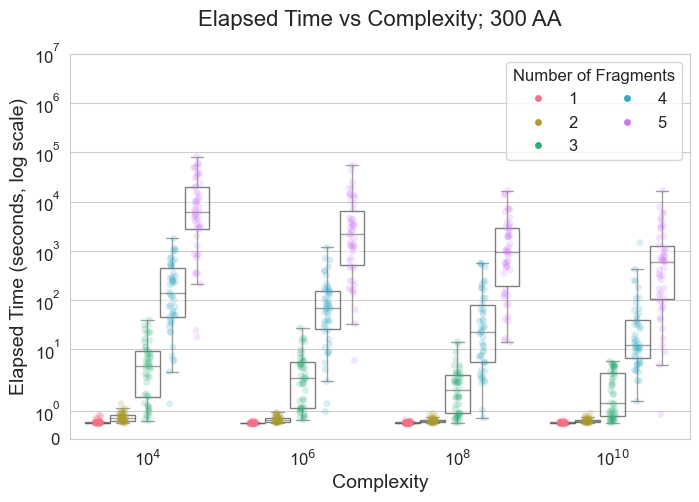

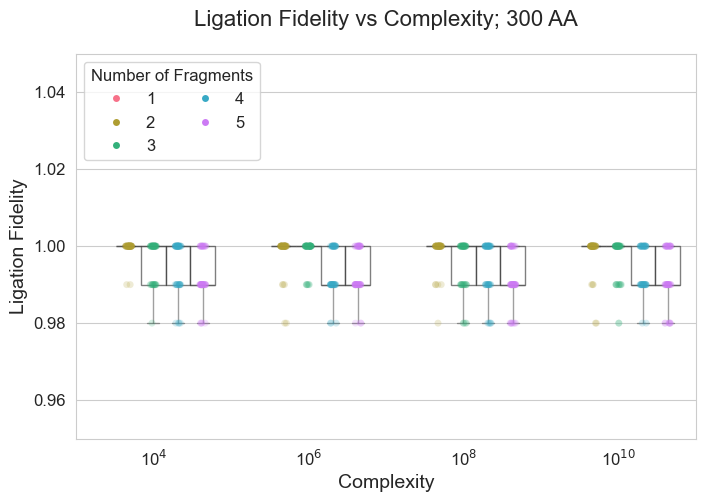

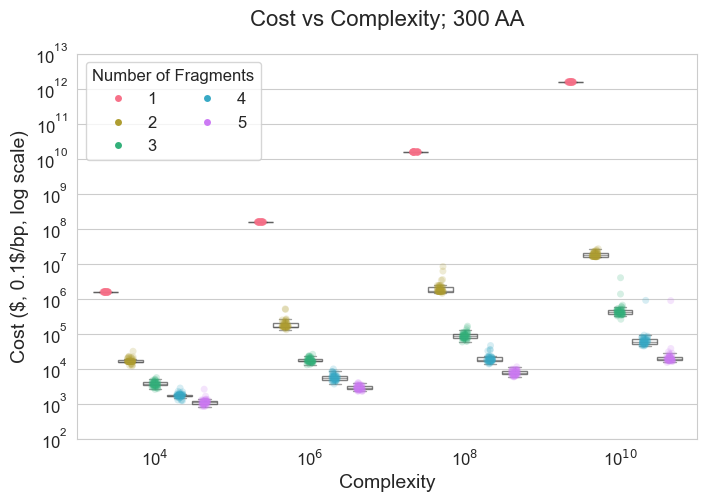

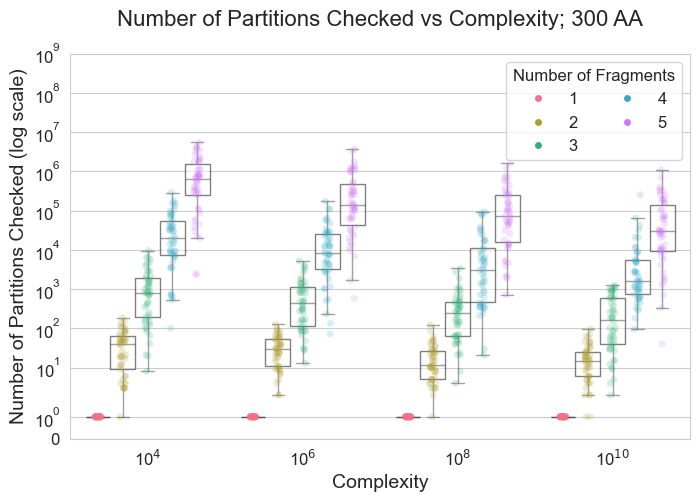

In [29]:
"""Plotting - Jitter + Box Plots"""

input_logy_spec = {
    "elapsed_time":True,
    "ligation_fidelity":False,
    "cost":True,
    # "fragment_length_unevenness":False,
    "number_of_partitions_checked":True,
    # "pass_constraint_percentage":True,
    # "num_of_checked_unique_partitions":True,
    # "elapsed_time_normalized_to_exhaustive":True
}
conds = ["10000","1000000","100000000", "10000000000"]

# # for x_axis in ['number_of_fragments','seq_length']:
# for x_axis in ['number_of_fragments']:
#
#     for y_axis, logy in input_logy_spec.items():
#         df = pd.DataFrame(res_data)
#         # df['complexity'] = pd.Categorical(df['complexity'], conds)
#         # df = df.sort_values('complexity')
#         plt = jitter_box_plot(x_axis, y_axis, df,
#                               my_palette=sns.color_palette(palette="husl", n_colors=len(conds)),
#                               hue='complexity', logy=logy)
#         plt.show()


for x_axis in ['complexity']:

    for y_axis, logy in input_logy_spec.items():
        df = pd.DataFrame(res_data)
        # df['complexity'] = pd.Categorical(df['complexity'], conds)
        # df = df.sort_values('complexity')
        plt = jitter_box_plot(x_axis, y_axis, df,
                              my_palette=sns.color_palette(palette="husl", n_colors=5),
                              hue='number_of_fragments', logy=logy)
        plt.show()
